# Initial thoughts

I want to start with some raw metrics like count of files, lines of code.
This is important to give me some context.
Example, if a package consists of 1 file, with 5 lines of code. Then naturally that package will have different metrics later on, such as no cyclomatic complexity, because the file only consists of imports.


# Dependencies setup

In [24]:
import os
import sys
import subprocess

def enforce_numpy_version():
    """
    Ensure that NumPy is installed and is a version below 2.x.
    If a 2.x version (or higher) is found, downgrade to a 1.x version
    and instruct the user to restart the kernel manually if running interactively.
    """
    try:
        import numpy as np
        major_version = int(np.__version__.split('.')[0])
        if major_version >= 2:
            print(f"Detected NumPy version {np.__version__}. Downgrading to numpy<2...")
            subprocess.check_call([sys.executable, "-m", "pip", "install", "--upgrade", "numpy<2"])
            if "ipykernel" in sys.modules:
                print("Please restart your Jupyter kernel manually after downgrading NumPy.")
                sys.exit(0)
            else:
                print("Restarting the script after downgrading NumPy...")
                os.execv(sys.executable, [sys.executable] + sys.argv)
        else:
            print(f"NumPy version {np.__version__} is compatible (version <2).")
    except ImportError:
        print("NumPy is not installed. Installing numpy<2...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "numpy<2"])
        if "ipykernel" in sys.modules:
            print("Please restart your Jupyter kernel manually after installing NumPy.")
            sys.exit(0)
        else:
            print("Restarting the script after installing NumPy...")
            os.execv(sys.executable, [sys.executable] + sys.argv)

def install_package(package):
    """
    Try to import a package. If it’s not found, install it using pip.
    If pip fails for any reason, catch the exception and print an error message.
    """
    try:
        # Replace dashes with underscores in case the module name differs from the package name.
        __import__(package.replace('-', '_'))
        print(f"{package} is already installed.")
    except ImportError:
        print(f"Installing {package}...")
        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", package])
        except subprocess.CalledProcessError as e:
            print(f"Failed to install {package}. Error: {e}")

if __name__ == "__main__":
    # Ensure NumPy is compatible before proceeding.
    enforce_numpy_version()
    
    # List of packages to install.
    packages = [
        'radon',
        'matplotlib',
        'pandas',
        'networkx',
        'pydot',
        'squarify',
        'pylint',
        'graphviz',
        'pyan3',
        'prospector'
    ]
    
    for pkg in packages:
        install_package(pkg)
    
    print("All packages have been checked and installed as needed.")


NumPy version 1.26.4 is compatible (version <2).
radon is already installed.
matplotlib is already installed.
pandas is already installed.
networkx is already installed.
pydot is already installed.
squarify is already installed.
pylint is already installed.
graphviz is already installed.
Installing pyan3...
prospector is already installed.
All packages have been checked and installed as needed.


In [25]:
import datetime
import os
import sys
import subprocess
import json
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from pathlib import Path
from collections import defaultdict
import networkx as nx

# Path setup

In [26]:
TOOLS_DIR = os.getcwd()  # Expected: ...\Tools
BASE_DIR = os.path.abspath(os.path.join(TOOLS_DIR, '..'))
DATA_DIR = os.path.join(BASE_DIR, 'Data')

# Our repos to analyse:
API_DIR = os.path.join(DATA_DIR, 'api')
WEB_DIR = os.path.join(DATA_DIR, 'web')

# Subdirectories for specific APIs:
API_ZEEGUU_DIR = os.path.join(DATA_DIR, 'api', 'zeeguu')
API_TOOLS_DIR = os.path.join(DATA_DIR, 'api', 'tools')

#Tools specific paths:
RADON_OUTPUT_DIR = os.path.join(BASE_DIR, 'output', 'radon')
os.makedirs(RADON_OUTPUT_DIR, exist_ok=True)

# Analyzation project(s) setup

In [27]:
def clone_repo(repo_url, target_dir):
    """
    Clone a git repository from repo_url into target_dir.
    Also create an empty __init__.py file in the repository's root.
    """
    # Ensure the parent directory exists.
    parent_dir = os.path.dirname(target_dir)
    if not os.path.exists(parent_dir):
        os.makedirs(parent_dir)
        print(f"Created parent directory: {parent_dir}")
    
    # Clone the repository if not already present.
    if not os.path.exists(target_dir):
        subprocess.run(["git", "clone", repo_url, target_dir], check=True)
        print(f"Repository cloned from {repo_url} into {target_dir}")
    else:
        print(f"Repository already exists at {target_dir}")
    
    # Create an empty __init__.py file in the repo root if it doesn't already exist.
    init_file = os.path.join(target_dir, '__init__.py')
    if not os.path.exists(init_file):
        open(init_file, 'w').close()  # This creates an empty file.
        print(f"Empty __init__.py created in {target_dir}")
    else:
        print(f"__init__.py already exists in {target_dir}")

# Clone the zeeguu/api repository.
clone_repo("https://github.com/zeeguu/api", API_DIR)

# Clone the zeeguu/web repository.
clone_repo("https://github.com/zeeguu/web", WEB_DIR)

Repository already exists at c:\Programming\Architecture\ArchitecturalRecovery\Data\api
__init__.py already exists in c:\Programming\Architecture\ArchitecturalRecovery\Data\api
Repository already exists at c:\Programming\Architecture\ArchitecturalRecovery\Data\web
__init__.py already exists in c:\Programming\Architecture\ArchitecturalRecovery\Data\web


# Radon

https://pypi.org/project/radon/

https://radon.readthedocs.io/en/latest/


## Why Radon

Radon is a tool i found great for providing code metrics, especially an overview of some of the common raw metrics like lines of code, number of functions, etc. This will give me a great initial overview, of where the work is placed in the project.


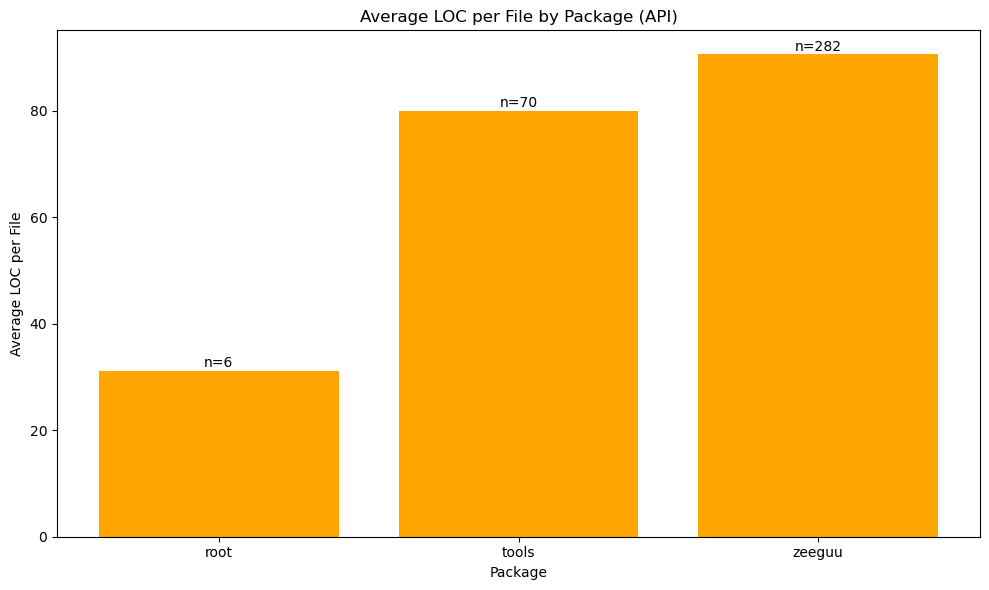

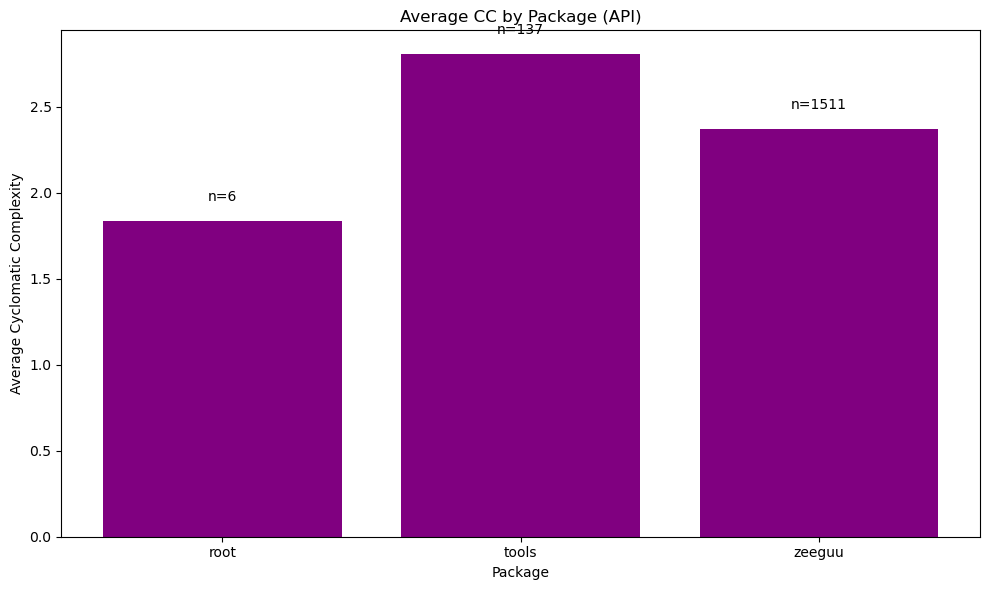

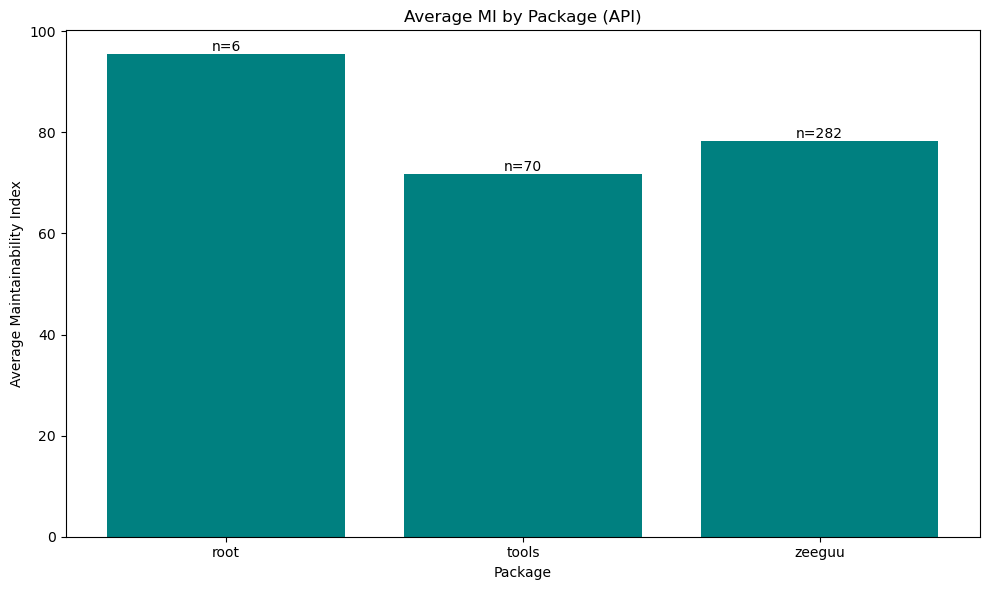

In [28]:
def aggregate_cc_by_package(base_dir):
    cmd = [sys.executable, "-m", "radon", "cc", base_dir, "-j", "-s", "-a"]
    result = subprocess.run(cmd, capture_output=True, text=True)
    data = json.loads(result.stdout)
    pkg_data = defaultdict(list)
    for filepath, funcs in data.items():
        relpath = os.path.relpath(filepath, base_dir)
        pkg = relpath.split(os.sep)[0] if os.sep in relpath else "root"
        for func in funcs:
            pkg_data[pkg].append(func["complexity"])
    return pkg_data

def aggregate_mi_by_package(base_dir):
    cmd = [sys.executable, "-m", "radon", "mi", base_dir, "-j"]
    result = subprocess.run(cmd, capture_output=True, text=True)
    data = json.loads(result.stdout)
    pkg_data = defaultdict(list)
    for filepath, mi_value in data.items():
        relpath = os.path.relpath(filepath, base_dir)
        pkg = relpath.split(os.sep)[0] if os.sep in relpath else "root"
        if isinstance(mi_value, dict):
            pkg_data[pkg].append(mi_value.get("mi", 0))
        else:
            pkg_data[pkg].append(mi_value)
    return pkg_data

def aggregate_raw_by_package(base_dir):
    cmd = [sys.executable, "-m", "radon", "raw", base_dir, "-j", "-s"]
    result = subprocess.run(cmd, capture_output=True, text=True)
    data = json.loads(result.stdout)
    metrics = ["loc", "lloc", "sloc", "comments", "single_comments", "multi", "blank"]
    pkg_totals = defaultdict(lambda: {metric: 0 for metric in metrics})
    pkg_file_count = defaultdict(int)
    for filepath, stats in data.items():
        relpath = os.path.relpath(filepath, base_dir)
        pkg = relpath.split(os.sep)[0] if os.sep in relpath else "root"
        pkg_file_count[pkg] += 1
        for metric in metrics:
            pkg_totals[pkg][metric] += stats.get(metric, 0)
    return pkg_totals, pkg_file_count

# --- Plot Average Cyclomatic Complexity by Package with annotations ---
if __name__ == "__main__":
    
    # --- Plot Average LOC per File by Package with annotations ---
    raw_pkg, pkg_file_count = aggregate_raw_by_package(API_DIR)
    pkg_names_raw = list(raw_pkg.keys())
    avg_loc = [raw_pkg[p]['loc'] / pkg_file_count[p] if pkg_file_count[p] else 0 for p in pkg_names_raw]

    plt.figure(figsize=(10, 6))
    bars = plt.bar(pkg_names_raw, avg_loc, color='orange')
    plt.xlabel("Package")
    plt.ylabel("Average LOC per File")
    plt.title("Average LOC per File by Package (API)")
    for bar, pkg in zip(bars, pkg_names_raw):
        count = pkg_file_count[pkg]
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, f"n={count}", ha='center', va='bottom', fontsize=10)
    plt.tight_layout()
    plt.savefig(os.path.join(RADON_OUTPUT_DIR, 'average_loc_by_package.png'))
    plt.show()
    
    # Aggregate cyclomatic complexity data
    cc_pkg = aggregate_cc_by_package(API_DIR)
    pkg_names = list(cc_pkg.keys())
    avg_cc = [sum(cc_pkg[p]) / len(cc_pkg[p]) if cc_pkg[p] else 0 for p in pkg_names]

    plt.figure(figsize=(10, 6))
    bars = plt.bar(pkg_names, avg_cc, color='purple')
    plt.xlabel("Package")
    plt.ylabel("Average Cyclomatic Complexity")
    plt.title("Average CC by Package (API)")
    for bar, pkg in zip(bars, pkg_names):
        count = len(cc_pkg[pkg])
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, f"n={count}", ha='center', va='bottom', fontsize=10)
    plt.tight_layout()
    plt.savefig(os.path.join(RADON_OUTPUT_DIR, 'average_cc_by_package.png'))
    plt.show()

    # --- Plot Average Maintainability Index by Package with annotations ---
    mi_pkg = aggregate_mi_by_package(API_DIR)
    pkg_names_mi = list(mi_pkg.keys())
    avg_mi = [sum(mi_pkg[p]) / len(mi_pkg[p]) if mi_pkg[p] else 0 for p in pkg_names_mi]

    plt.figure(figsize=(10, 6))
    bars = plt.bar(pkg_names_mi, avg_mi, color='teal')
    plt.xlabel("Package")
    plt.ylabel("Average Maintainability Index")
    plt.title("Average MI by Package (API)")
    for bar, pkg in zip(bars, pkg_names_mi):
        count = len(mi_pkg[pkg])
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, f"n={count}", ha='center', va='bottom', fontsize=10)
    plt.tight_layout()
    plt.savefig(os.path.join(RADON_OUTPUT_DIR, 'average_mi_by_package.png'))
    plt.show()



### Intermediate Analysis

Here we can quickly see that the root only has 6 functions and few lines of code.
Most of the code resides in either /Tools or /Zeeguu, having around 80 lines of code per file, where as Tools consists of 70 functions and zeeguu has the majority of code, containing 282 functions.

Besides Lines of Code and number of functions, Radon will also provide:
* Cyclomatic Complexity, which looks at number of decisions a block of code contains
* Maintainability index. Which is a combination of 4 other metrics https://radon.readthedocs.io/en/latest/intro.html#maintainability-index, being the Halstead index (https://radon.readthedocs.io/en/latest/intro.html#halstead-metrics), which looks at distinct number of operators and operands compared to the total number. As well as the Cyclomatic Complexity, Source Lines of Code (SLOC), and number of comments. A low Maintainability index is bad, and a high one is good.

We can see that Tools have a higher CC and lower maintainabiltiy index than Zeeguu.

So now i want to check the subdirectories in /Tools and /Zeeguu

Running analysis for: zeeguu (Directory: c:\Programming\Architecture\ArchitecturalRecovery\Data\api\zeeguu)


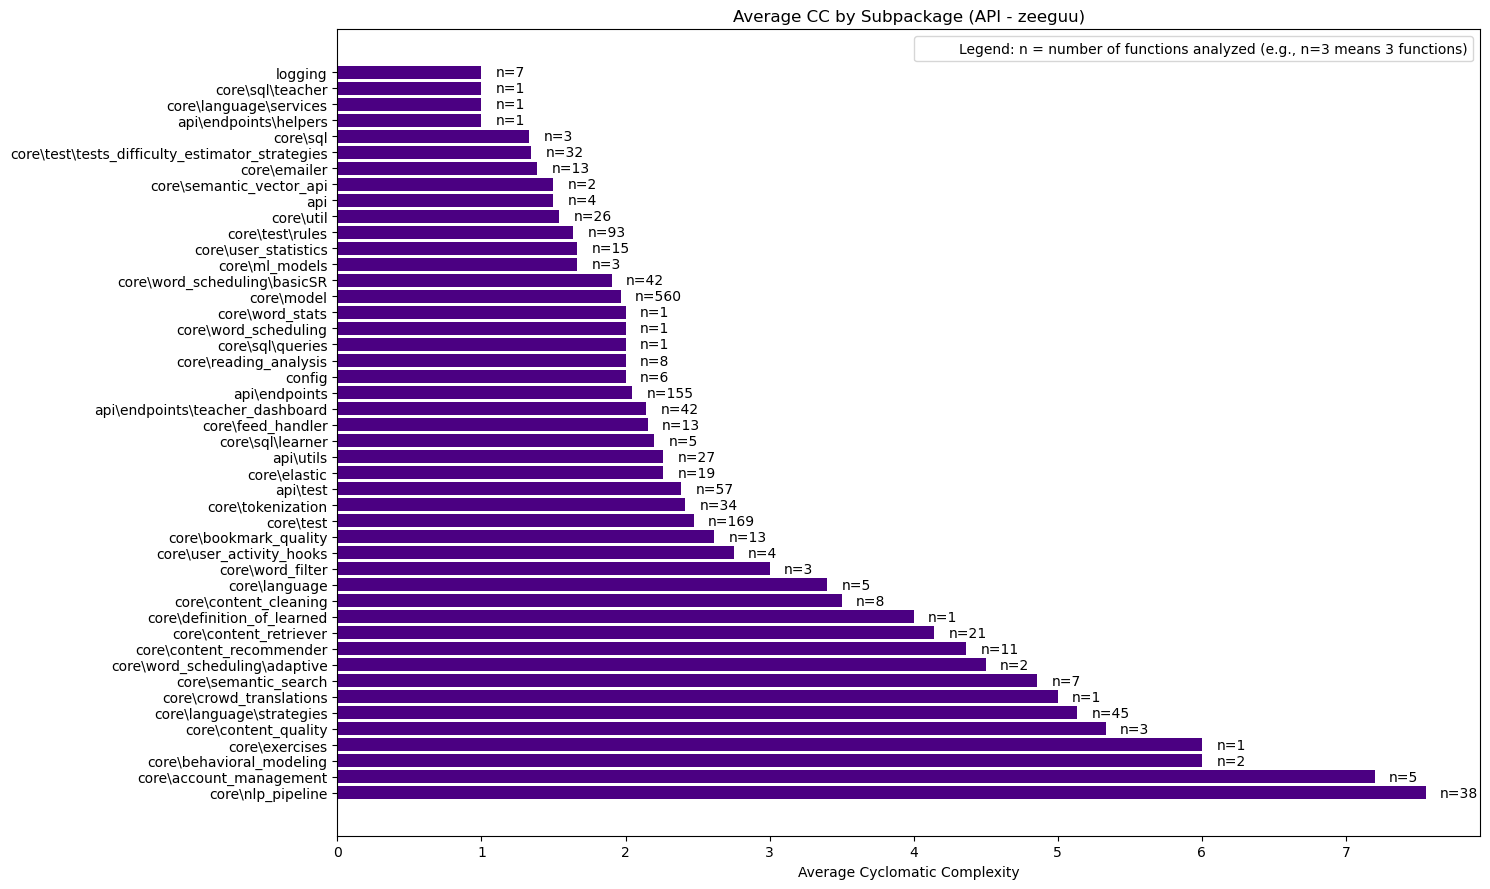

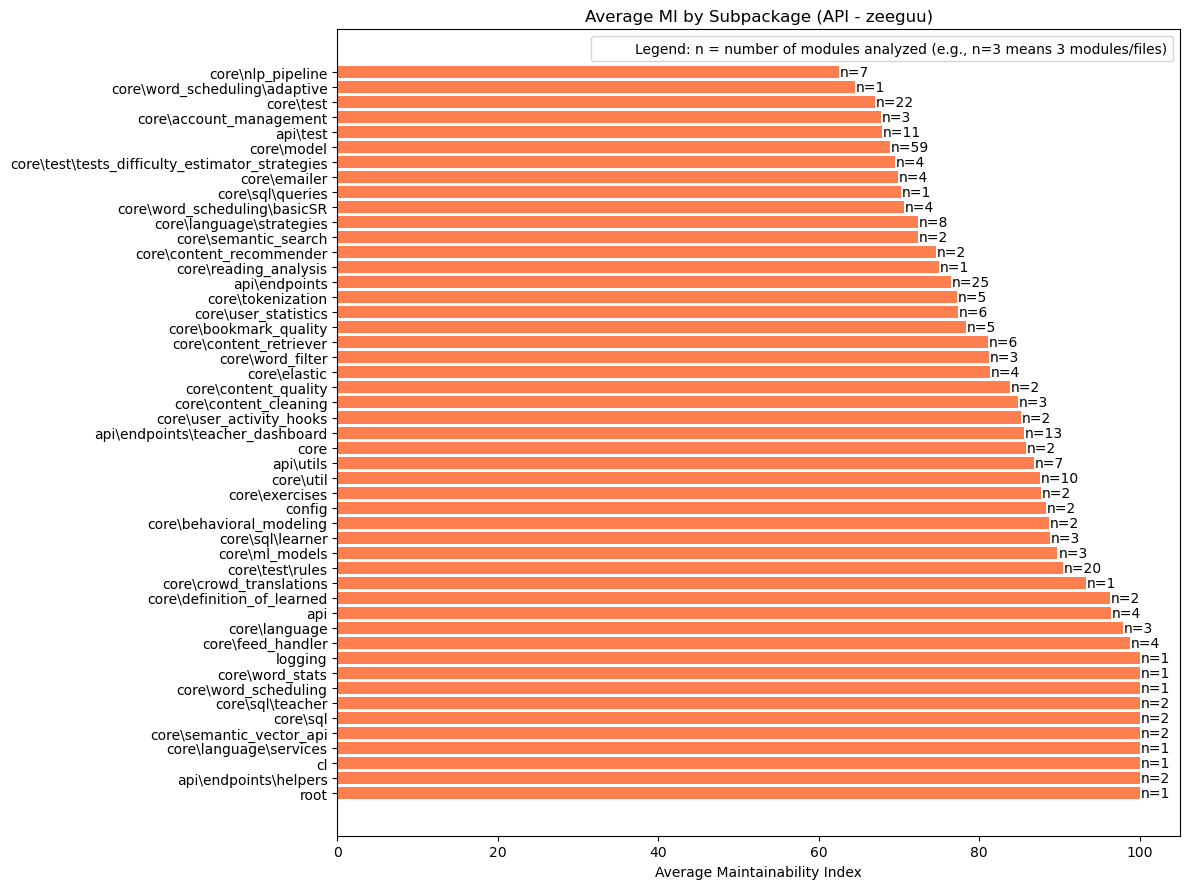

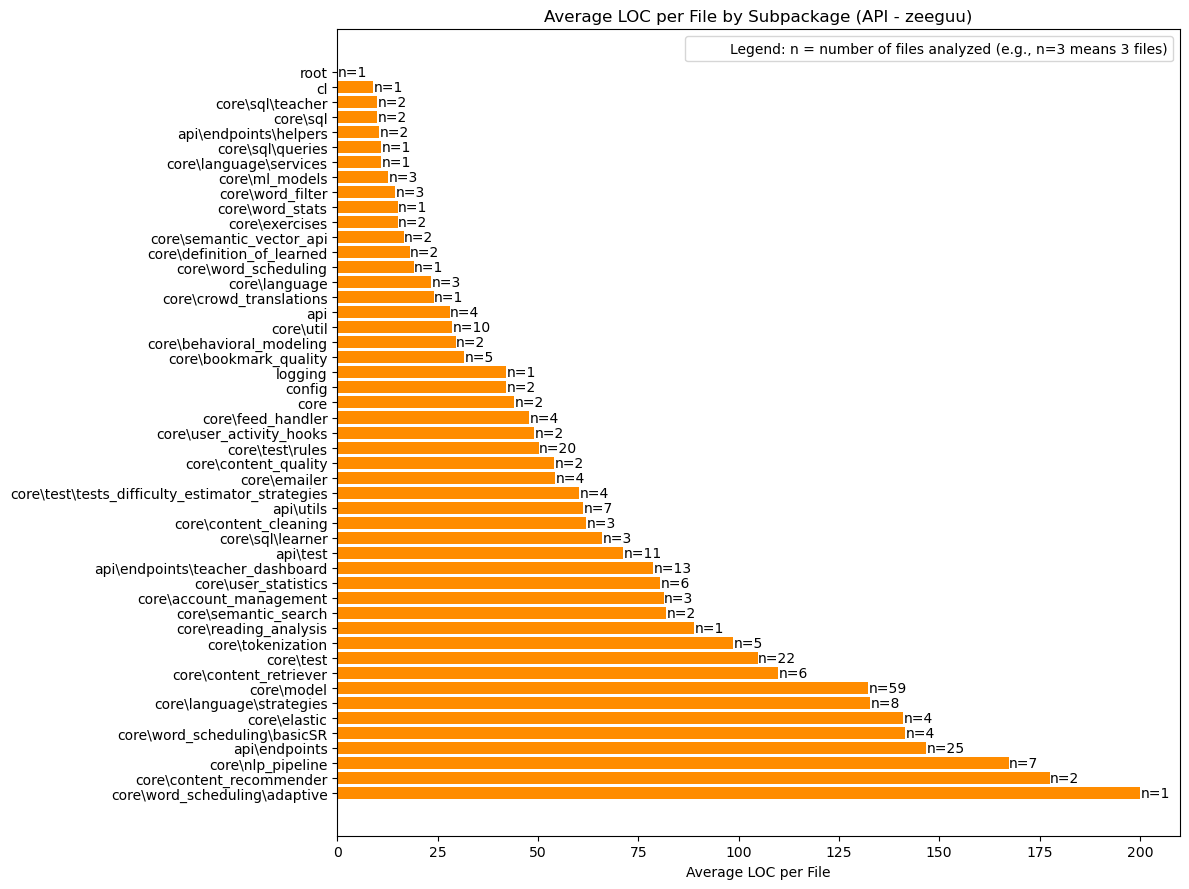

Running analysis for: tools (Directory: c:\Programming\Architecture\ArchitecturalRecovery\Data\api\tools)


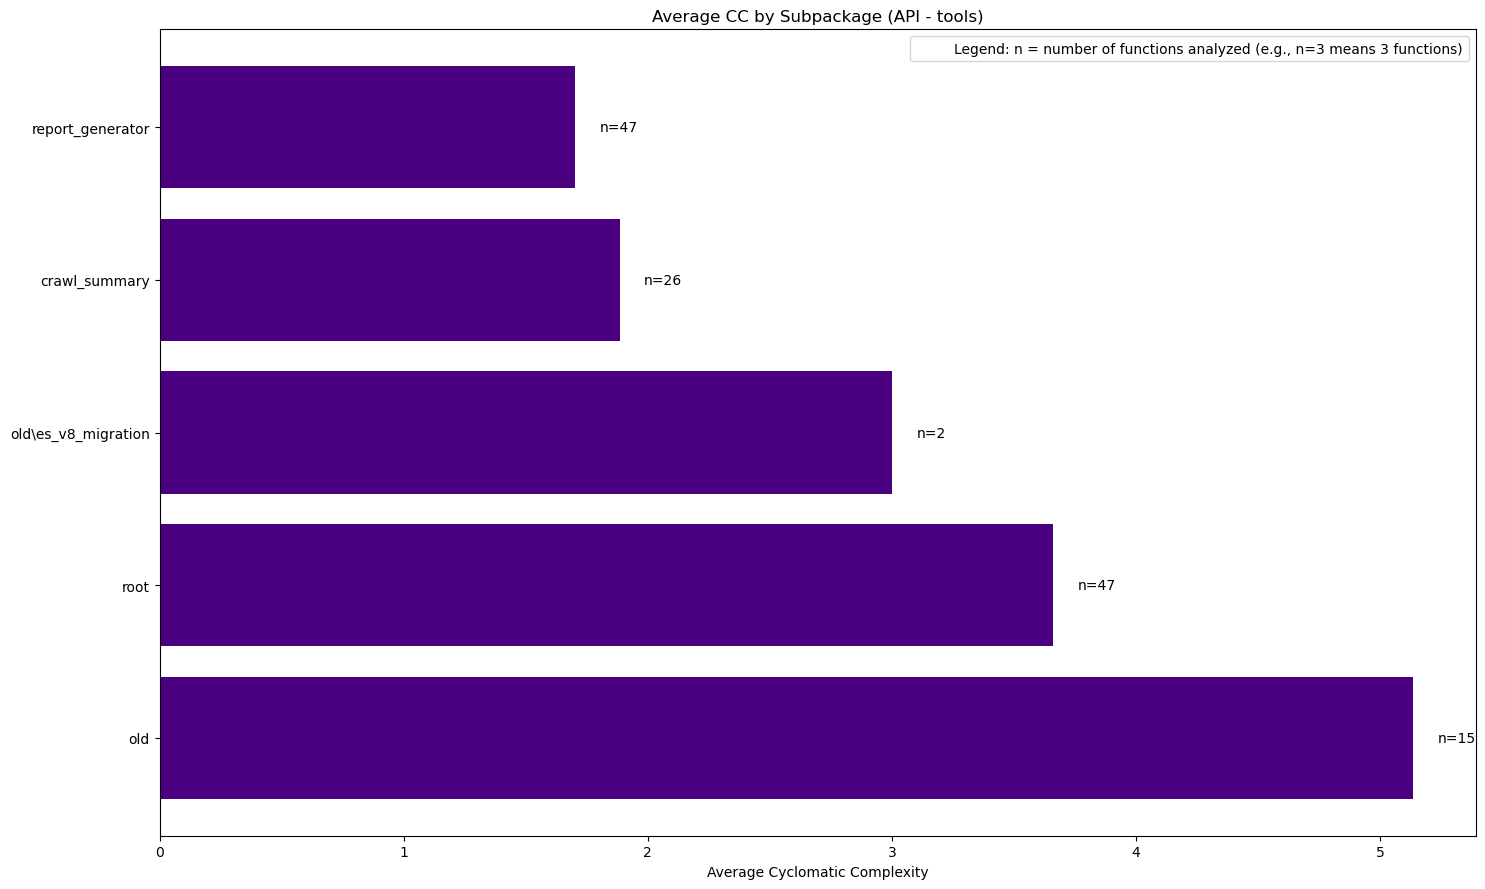

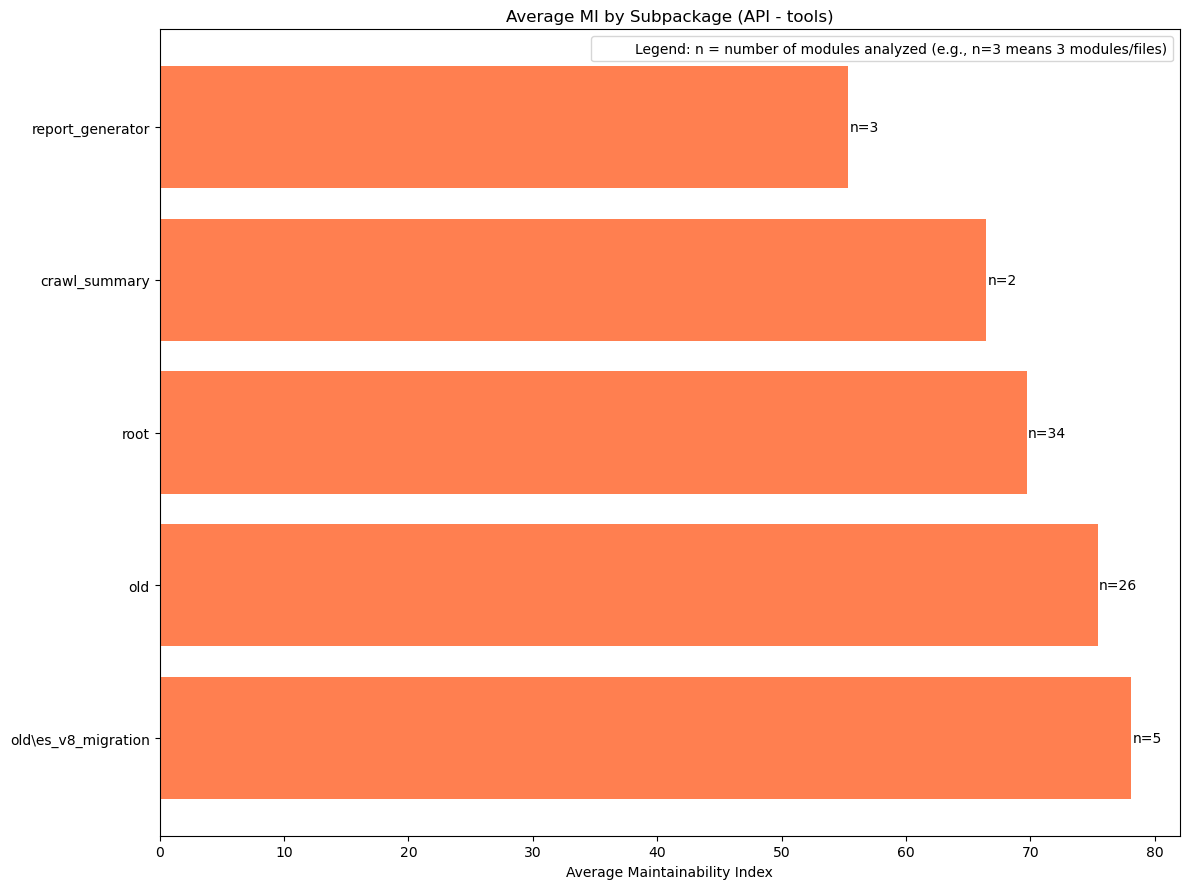

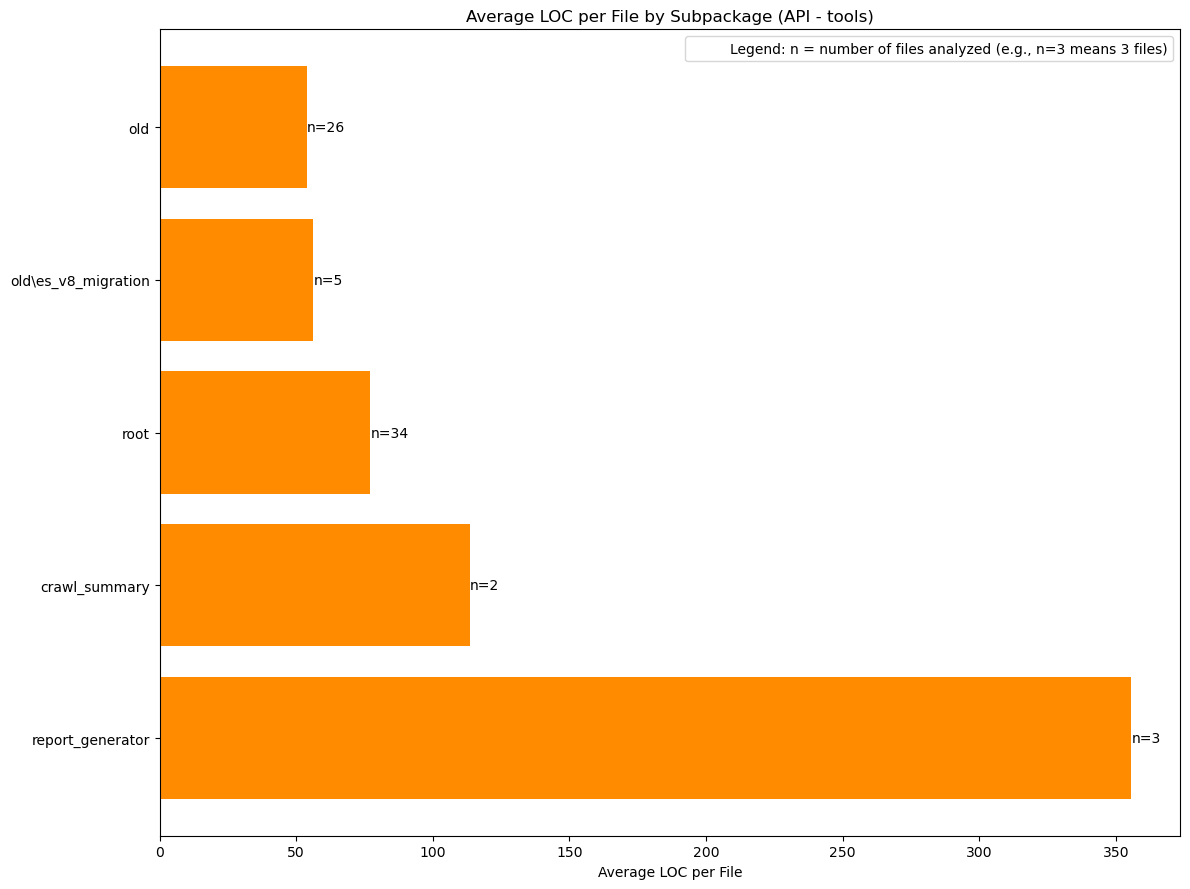

In [31]:
def aggregate_cc_by_subpackage(base_dir):
    """Aggregate Cyclomatic Complexity (CC) per subpackage using radon cc."""
    cmd = [sys.executable, "-m", "radon", "cc", base_dir, "-j", "-s", "-a"]
    result = subprocess.run(cmd, capture_output=True, text=True)
    data = json.loads(result.stdout)
    pkg_data = defaultdict(list)
    for filepath, funcs in data.items():
        relpath = os.path.relpath(filepath, base_dir)
        pkg = os.path.dirname(relpath)
        if pkg == "":
            pkg = "root"
        for func in funcs:
            pkg_data[pkg].append(func["complexity"])
    return pkg_data

def aggregate_mi_by_subpackage(base_dir):
    """Aggregate Maintainability Index (MI) per subpackage using radon mi."""
    cmd = [sys.executable, "-m", "radon", "mi", base_dir, "-j"]
    result = subprocess.run(cmd, capture_output=True, text=True)
    data = json.loads(result.stdout)
    pkg_data = defaultdict(list)
    for filepath, mi_value in data.items():
        relpath = os.path.relpath(filepath, base_dir)
        pkg = os.path.dirname(relpath)
        if pkg == "":
            pkg = "root"
        if isinstance(mi_value, dict):
            pkg_data[pkg].append(mi_value.get("mi", 0))
        else:
            pkg_data[pkg].append(mi_value)
    return pkg_data

def aggregate_raw_by_subpackage(base_dir):
    """Aggregate raw metrics (e.g., LOC) per subpackage using radon raw."""
    cmd = [sys.executable, "-m", "radon", "raw", base_dir, "-j", "-s"]
    result = subprocess.run(cmd, capture_output=True, text=True)
    data = json.loads(result.stdout)
    metrics = ["loc", "lloc", "sloc", "comments", "single_comments", "multi", "blank"]
    pkg_totals = defaultdict(lambda: {metric: 0 for metric in metrics})
    pkg_file_count = defaultdict(int)
    for filepath, stats in data.items():
        relpath = os.path.relpath(filepath, base_dir)
        pkg = os.path.dirname(relpath)
        if pkg == "":
            pkg = "root"
        pkg_file_count[pkg] += 1
        for metric in metrics:
            pkg_totals[pkg][metric] += stats.get(metric, 0)
    return pkg_totals, pkg_file_count

# -------------------------
# Sorting Helper
# -------------------------
def sort_metric(pkg_names, metric_values, reverse=True):
    """Sort two parallel lists by metric_values.
       Set reverse=True for descending order or False for ascending."""
    sorted_pairs = sorted(zip(pkg_names, metric_values), key=lambda x: x[1], reverse=reverse)
    return zip(*sorted_pairs)  # returns (sorted_names, sorted_values)

# -------------------------
# Main Analysis Execution
# -------------------------
if __name__ == "__main__":
    # Define analysis targets as tuples: (label, directory)
    analysis_targets = [
        ("zeeguu", API_ZEEGUU_DIR),
        ("tools", API_TOOLS_DIR)
    ]
    
    for label, analysis_dir in analysis_targets:
        print(f"Running analysis for: {label} (Directory: {analysis_dir})")
        
        # ---- Cyclomatic Complexity (CC) by Subpackage ----
        cc_subpkg = aggregate_cc_by_subpackage(analysis_dir)
        subpkg_names = list(cc_subpkg.keys())
        avg_cc = [sum(cc_subpkg[p]) / len(cc_subpkg[p]) if cc_subpkg[p] else 0 for p in subpkg_names]
        
        # Sort by average CC (descending order)
        sorted_names_cc, sorted_avg_cc = sort_metric(subpkg_names, avg_cc, reverse=True)
        
        plt.figure(figsize=(15, 9))
        bars = plt.barh(list(sorted_names_cc), list(sorted_avg_cc), color='indigo')
        plt.xlabel("Average Cyclomatic Complexity")
        plt.title(f"Average CC by Subpackage (API - {label})")
        for bar, pkg in zip(bars, sorted_names_cc):
            count = len(cc_subpkg[pkg])
            plt.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2,
                     f"n={count}", va='center', fontsize=10)
        # Add Legend for CC Plot (explanation for n)
        legend_cc = mpatches.Patch(color='none',
                                   label="Legend: n = number of functions analyzed (e.g., n=3 means 3 functions)")
        plt.legend(handles=[legend_cc], loc='upper right', frameon=True)
        plt.tight_layout()
        cc_filename = os.path.join(RADON_OUTPUT_DIR, f'average_cc_by_subpackage_{label}.png')
        plt.savefig(cc_filename)
        plt.show()

        # ---- Maintainability Index (MI) by Subpackage ----
        mi_subpkg = aggregate_mi_by_subpackage(analysis_dir)
        subpkg_names_mi = list(mi_subpkg.keys())
        avg_mi = [sum(mi_subpkg[p]) / len(mi_subpkg[p]) if mi_subpkg[p] else 0 for p in subpkg_names_mi]
        
        # Sort by average MI (descending order)
        sorted_names_mi, sorted_avg_mi = sort_metric(subpkg_names_mi, avg_mi, reverse=True)
        
        plt.figure(figsize=(12, 9))
        bars = plt.barh(list(sorted_names_mi), list(sorted_avg_mi), color='coral')
        plt.xlabel("Average Maintainability Index")
        plt.title(f"Average MI by Subpackage (API - {label})")
        for bar, pkg in zip(bars, sorted_names_mi):
            count = len(mi_subpkg[pkg])
            plt.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2,
                     f"n={count}", va='center', fontsize=10)
        # Add Legend for MI Plot
        legend_mi = mpatches.Patch(color='none',
                                   label="Legend: n = number of modules analyzed (e.g., n=3 means 3 modules/files)")
        plt.legend(handles=[legend_mi], loc='upper right', frameon=True)
        plt.tight_layout()
        mi_filename = os.path.join(RADON_OUTPUT_DIR, f'average_mi_by_subpackage_{label}.png')
        plt.savefig(mi_filename)
        plt.show()

        # ---- Raw Metrics (using LOC as an example) by Subpackage ----
        raw_subpkg, subpkg_file_count = aggregate_raw_by_subpackage(analysis_dir)
        subpkg_names_raw = list(raw_subpkg.keys())
        avg_loc = [raw_subpkg[p]['loc'] / subpkg_file_count[p] if subpkg_file_count[p] else 0 for p in subpkg_names_raw]
        
        # Sort by average LOC (descending order)
        sorted_names_loc, sorted_avg_loc = sort_metric(subpkg_names_raw, avg_loc, reverse=True)
        
        plt.figure(figsize=(12, 9))
        bars = plt.barh(list(sorted_names_loc), list(sorted_avg_loc), color='darkorange')
        plt.xlabel("Average LOC per File")
        plt.title(f"Average LOC per File by Subpackage (API - {label})")
        for bar, pkg in zip(bars, sorted_names_loc):
            count = subpkg_file_count[pkg]
            plt.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2,
                     f"n={count}", va='center', fontsize=10)
        # Add Legend for LOC Plot
        legend_loc = mpatches.Patch(color='none',
                                    label="Legend: n = number of files analyzed (e.g., n=3 means 3 files)")
        plt.legend(handles=[legend_loc], loc='upper right', frameon=True)
        plt.tight_layout()
        raw_filename = os.path.join(RADON_OUTPUT_DIR, f'average_loc_by_subpackage_{label}.png')
        plt.savefig(raw_filename)
        plt.show()

### Intermediate analysis

Kinda funny, but here we can see a package called "old", being a relative small package which also have a very high CC, most likely because it has been identified as a weak point and is being slowly refactored away.

We also notice that most files are placed directly in the root of tools, whereas for the zeeguu project, it is placed in various subdirectories under the zeeguu project. This need for more components is also indicated by the huge size of the zeeguu directory, as to increase the maintainability.



### Trying to identify weak-spots

By sorting the whole project based on the metrics shown thus far:

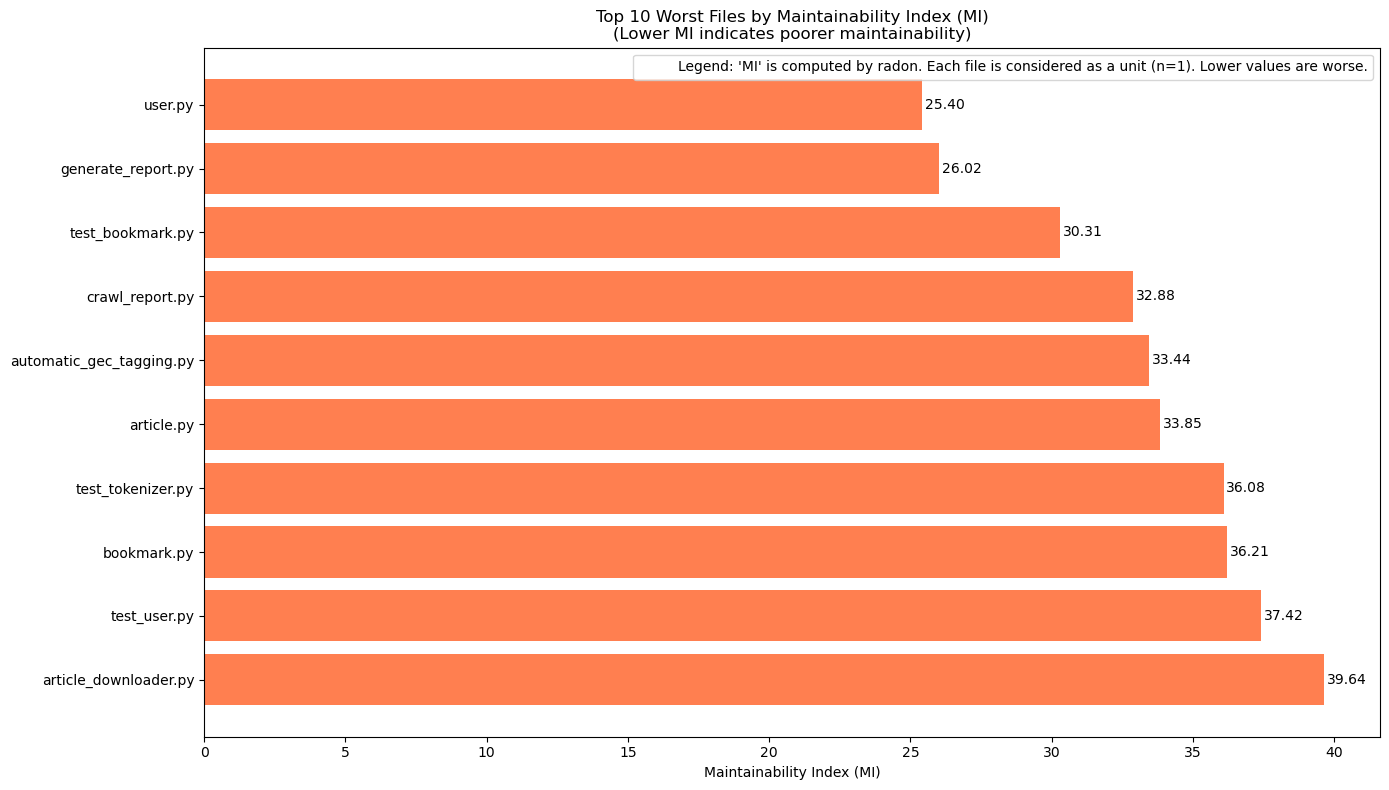

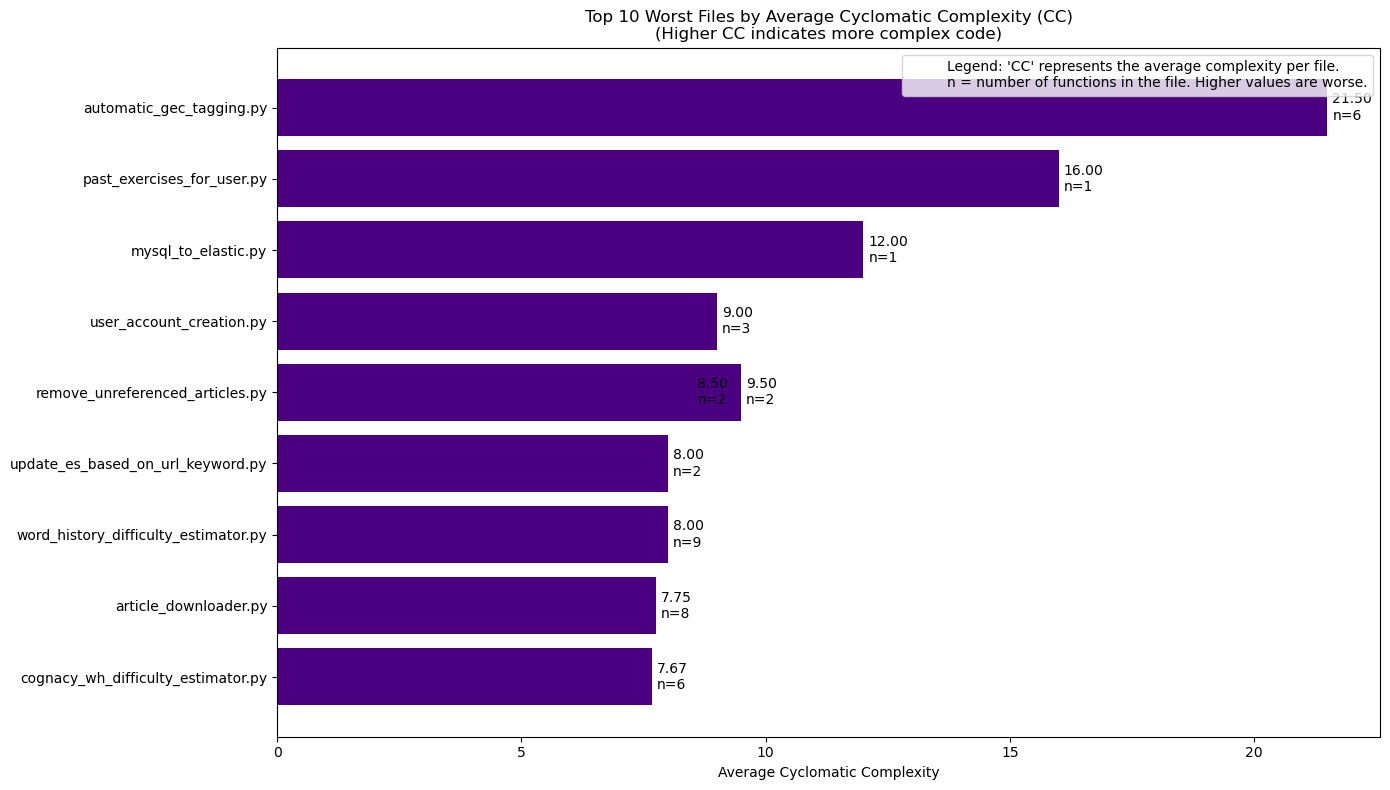

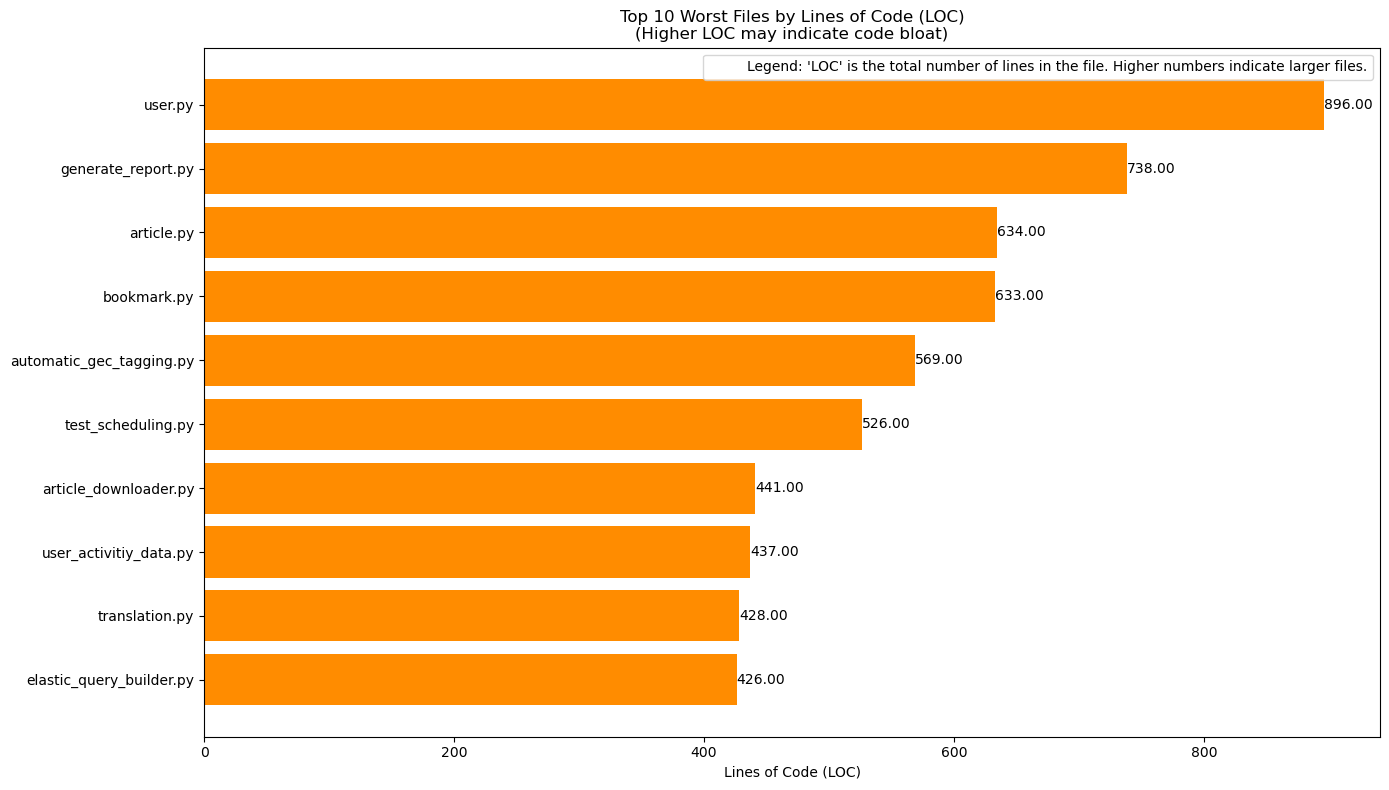

In [34]:
def get_worst_mi_files(base_dir, top=10):
    """
    Run 'radon mi' on base_dir and return a list of tuples (filepath, mi)
    sorted in ascending order (lowest MI is worst). For plotting, we then reverse
    the list so that the worst file appears at the top.
    """
    cmd = [sys.executable, "-m", "radon", "mi", base_dir, "-j"]
    result = subprocess.run(cmd, capture_output=True, text=True)
    data = json.loads(result.stdout)
    file_mi = {}
    for filepath, mi in data.items():
        try:
            mi_val = mi["mi"] if isinstance(mi, dict) else mi
        except Exception:
            mi_val = 0
        file_mi[filepath] = mi_val
    # Lower MI is worse.
    worst = sorted(file_mi.items(), key=lambda x: x[1])[:top]
    # Reverse for plotting so that the worst (lowest MI) appears at the top.
    return worst[::-1]

def get_worst_cc_files(base_dir, top=10):
    """
    Run 'radon cc' on base_dir and compute average cyclomatic complexity per file.
    Also record the number of functions per file. Return a list of tuples:
    (filepath, avg_cc, count) sorted in descending order (highest avg_cc is worst),
    then reversed for plotting.
    """
    cmd = [sys.executable, "-m", "radon", "cc", base_dir, "-j", "-s", "-a"]
    result = subprocess.run(cmd, capture_output=True, text=True)
    data = json.loads(result.stdout)
    file_cc = {}
    file_cc_count = {}
    for filepath, funcs in data.items():
        if funcs:
            avg_cc = sum(func["complexity"] for func in funcs) / len(funcs)
            count = len(funcs)
        else:
            avg_cc = 0
            count = 0
        file_cc[filepath] = avg_cc
        file_cc_count[filepath] = count
    worst = sorted(file_cc.items(), key=lambda x: x[1], reverse=True)[:top]
    # Build list of triples: (filepath, avg_cc, count)
    worst_with_counts = [(fp, file_cc[fp], file_cc_count[fp]) for fp, _ in worst]
    return worst_with_counts[::-1]

def get_worst_loc_files(base_dir, top=10):
    """
    Run 'radon raw' on base_dir and extract the total LOC per file.
    Return a list of tuples (filepath, loc) sorted in descending order (highest LOC is worst),
    then reversed for plotting.
    """
    cmd = [sys.executable, "-m", "radon", "raw", base_dir, "-j", "-s"]
    result = subprocess.run(cmd, capture_output=True, text=True)
    data = json.loads(result.stdout)
    file_loc = {}
    for filepath, stats in data.items():
        loc = stats.get("loc", 0)
        file_loc[filepath] = loc
    worst = sorted(file_loc.items(), key=lambda x: x[1], reverse=True)[:top]
    return worst[::-1]

# -------------------------
# Plotting Helper Function
# -------------------------
def plot_metric(metric_data, metric_label, title, legend_text, save_filename, bar_color):
    """
    Plot a horizontal bar chart for the given metric data.
    metric_data: list of tuples. For MI and LOC: (filepath, value).
                 For CC: (filepath, value, count).
    If the tuple has three elements, the annotation will combine the metric value
    and the count (with a newline) so that the worst file shows, for example: 
    "8.50\nn=9" on the bar.
    """
    if not metric_data:
        print("No metric data to plot.")
        return

    # Check if our data tuples have 2 or 3 items
    tuple_length = len(metric_data[0])
    
    # Unzip file names and values (and count if present)
    if tuple_length == 2:
        file_names, values = zip(*metric_data)
        annotations = [f"{v:.2f}" for v in values]
    elif tuple_length == 3:
        file_names, values, counts = zip(*metric_data)
        # Combine value and count in one label with a newline.
        annotations = [f"{v:.2f}\nn={c}" for v, c in zip(values, counts)]
    else:
        raise ValueError("Unexpected tuple length in metric data.")
    
    # Use only the basename for display
    display_names = [os.path.basename(name) for name in file_names]
    
    plt.figure(figsize=(14, 8))
    bars = plt.barh(display_names, values, color=bar_color)
    plt.xlabel(metric_label)
    plt.title(title)
    
    # Annotate each bar; adjust vertical position slightly if necessary.
    for bar, label in zip(bars, annotations):
        plt.text(bar.get_width() + 0.1, 
                 bar.get_y() + bar.get_height() / 2,
                 label, va='center', fontsize=10)
    
    # Add legend in the upper-right corner
    legend_patch = mpatches.Patch(color='none', label=legend_text)
    plt.legend(handles=[legend_patch], loc='upper right', frameon=True)
    
    plt.tight_layout()
    plt.savefig(save_filename)
    plt.show()

# -------------------------
# Main Execution: Whole-Project Analysis (API_DIR)
# -------------------------
if __name__ == "__main__":
    # Use the entire API project directory.
    analysis_dir = API_DIR

    # -- Worst Files by Maintainability Index (MI) --
    worst_mi = get_worst_mi_files(analysis_dir, top=10)
    mi_plot_title = ("Top 10 Worst Files by Maintainability Index (MI)\n"
                     "(Lower MI indicates poorer maintainability)")
    mi_legend = ("Legend: 'MI' is computed by radon. Each file is considered as a unit (n=1). "
                 "Lower values are worse.")
    mi_filename = os.path.join(RADON_OUTPUT_DIR, 'worst_mi_files.png')
    plot_metric(worst_mi,
                metric_label="Maintainability Index (MI)",
                title=mi_plot_title,
                legend_text=mi_legend,
                save_filename=mi_filename,
                bar_color="coral")
    
    # -- Worst Files by Cyclomatic Complexity (CC) --
    worst_cc = get_worst_cc_files(analysis_dir, top=10)
    cc_plot_title = ("Top 10 Worst Files by Average Cyclomatic Complexity (CC)\n"
                     "(Higher CC indicates more complex code)")
    cc_legend = ("Legend: 'CC' represents the average complexity per file.\n"
                 "n = number of functions in the file. Higher values are worse.")
    cc_filename = os.path.join(RADON_OUTPUT_DIR, 'worst_cc_files.png')
    plot_metric(worst_cc,
                metric_label="Average Cyclomatic Complexity",
                title=cc_plot_title,
                legend_text=cc_legend,
                save_filename=cc_filename,
                bar_color="indigo")
    
    # -- Worst Files by Lines of Code (LOC) --
    worst_loc = get_worst_loc_files(analysis_dir, top=10)
    loc_plot_title = ("Top 10 Worst Files by Lines of Code (LOC)\n"
                      "(Higher LOC may indicate code bloat)")
    loc_legend = ("Legend: 'LOC' is the total number of lines in the file. "
                  "Higher numbers indicate larger files.")
    loc_filename = os.path.join(RADON_OUTPUT_DIR, 'worst_loc_files.png')
    plot_metric(worst_loc,
                metric_label="Lines of Code (LOC)",
                title=loc_plot_title,
                legend_text=loc_legend,
                save_filename=loc_filename,
                bar_color="darkorange")

### Conclusion

While this might show weak-spots, it is also more likely that this also simply shows where most things are happening.
Such as the generate_report.py might have low maintainability and high lines of code, but it might also be a deep-module, which performs a lot of actions, compared to the narrowness of its interface.

We might get more of a indication of this, by looking at which modules calls/depends on what.

# GitTruck

# Prospector

# Pyan

# Pyreverse

# Tools i couldn't get working

## Snakefood
https://github.com/blais/snakefood

Did not work because:

"Python-3.x is NOT supported, but there have been a few efforts to port to it. I never had time to fully port it; it would require a fair bit of a rewrite to do so IMO."

## PyCallGraph

https://pycallgraph.readthedocs.io/en/master/

Couldn't get it to work. Chased down a never-ending rabbithole.

1. Can't find entrypoint / main. Most likely due to the complexity of how the project is run.
2. If we try to help it and give some modules a main(), it then can't figure out the dependencies
3. If we add the dependencies, they haven't been setup properly.
4. Setting them up properly is too hard.

## Architectural-Lens

https://github.com/Perlten/Architectural-Lens/tree/master

Couldn't get it to generate a non-empty .json file.
* Tried directly through command-line
* Tried through python notebook
* Tried feeding documentation to LLM
* Tried on friends PC